In [1]:
import sys
import random
import numpy as np
from time import time
from pathlib import Path
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, CSVLogger
from tensorflow.keras import mixed_precision

# from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.functional.hrnet_keras import HRNet
from data_loaders import CityscapesLoader, CityscapesLoaderTFDS


physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    # mixed_precision.experimental.set_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 



In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

A bunch of command line stuff for accessing GCP bucket data

```
echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main" | sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list

sudo apt-get install apt-transport-https ca-certificates gnupg

curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key --keyring /usr/share/keyrings/cloud.google.gpg add -

sudo apt-get update && sudo apt-get install google-cloud-sdk

gcloud init --console-only

```

```
gsutil cp gs://cl_datasets_01/cityscapes/records/trainIds_train.record /home/ubuntu/cityscapes_cv/records/
gsutil cp gs://cl_datasets_01/cityscapes/records/trainIds_val.record /home/ubuntu/cityscapes_cv/records/
gsutil cp gs://cl_datasets_01/cityscapes/records/trainIds_train_extra.record /home/ubuntu/cityscapes_cv/records/
```

In [3]:
fine = True

n_classes = 20
img_height = 512
img_width = 1024

BATCH_SIZE = 6
BUFFER_SIZE = 256

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

After making the scripts to manually create and store the Cityscapes dataset, I realized that it can be easily downloaded using Tensorflow Datasets API. The commented out code is for using the manually created dataset

In [4]:
pipeline = CityscapesLoaderTFDS(
    img_height=img_height, 
    img_width=img_width, 
    n_classes=n_classes
)

In [5]:
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [6]:
dataset, info = tfds.load(
    name = 'cityscapes/semantic_segmentation', 
    data_dir = '/workspace/tensorflow_datasets/', 
    with_info = True,
    shuffle_files=True
)

In [7]:
dataset['train']

<_OptionsDataset shapes: {image_id: (), image_left: (1024, 2048, 3), segmentation_label: (1024, 2048, 1)}, types: {image_id: tf.string, image_left: tf.uint8, segmentation_label: tf.uint8}>

In [8]:
train = dataset['train'].map(pipeline.load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
valid = dataset['validation'].map(pipeline.load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = dataset['validation'].map(pipeline.load_image_eval, num_parallel_calls=tf.data.AUTOTUNE)

TRAIN_LENGTH = info.splits['train'].num_examples
VALID_LENGTH = info.splits['validation'].num_examples

# train_ds = get_dataset_from_tfrecord("records/trainIds_train.record")
# valid_ds = get_dataset_from_tfrecord("records/trainIds_val.record")

# TRAIN_LENGTH = 2975
# VALID_LENGTH = 500

# train = train_ds.map(pipeline.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# valid = valid_ds.map(pipeline.load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# eval_ds = valid_ds.map(pipeline.load_image_eval, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
# Preprocessing: random crop the images and masks, flip them
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [10]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5)) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

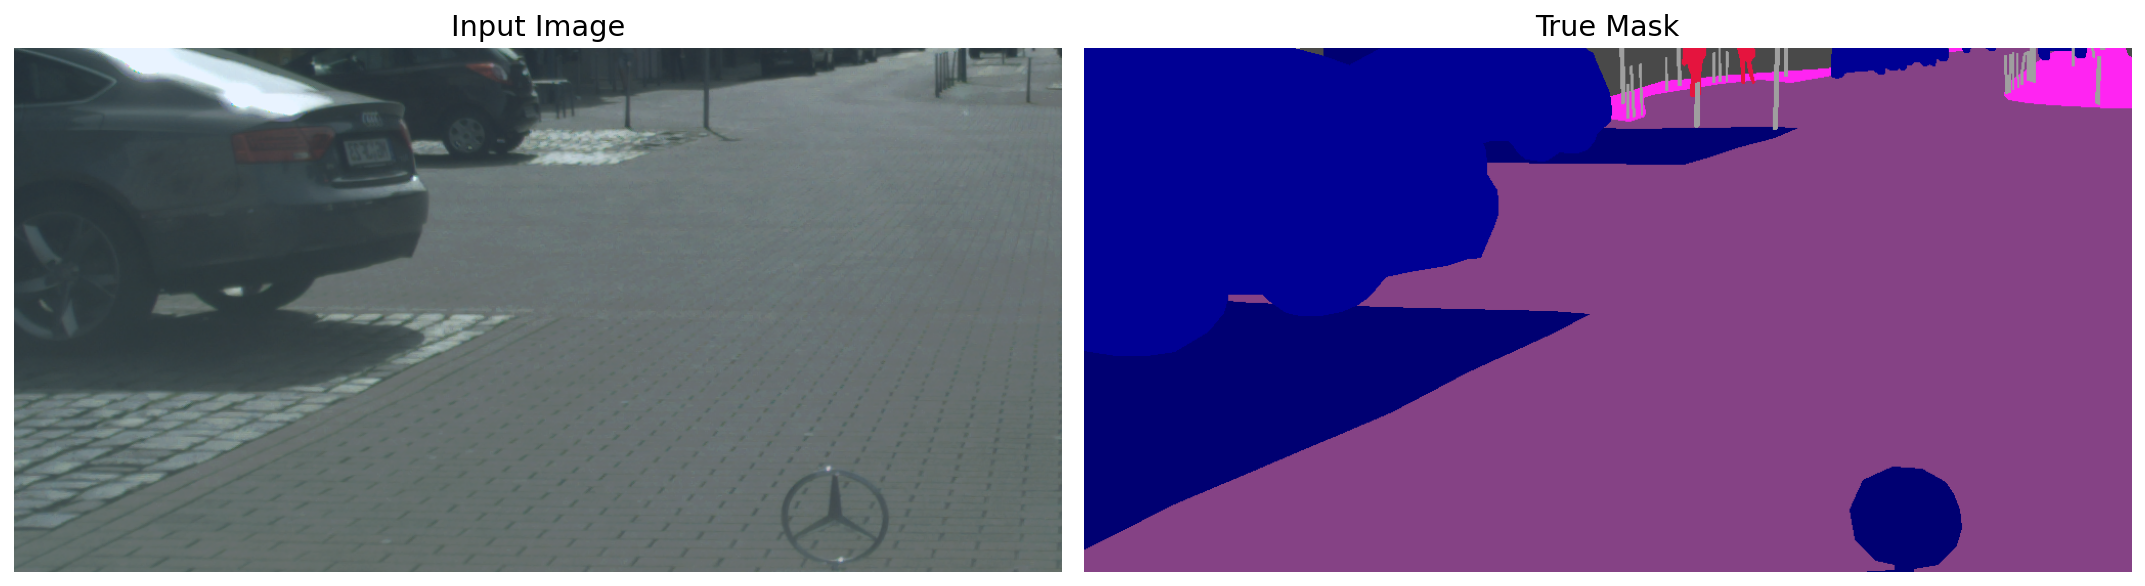

In [11]:
for image, mask in train.take(3): 
    sample_image, sample_mask = image, mask

sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [13]:
MODEL_PATH = "weights/HRNet_W48.h5"

In [14]:
model = HRNet(input_height=img_height, input_width=img_width, n_classes=n_classes, W=48)

In [15]:
model.load_weights("weights/HRNet_CLF_W48.h5", by_name=True, skip_mismatch=True)

In [16]:
# model.summary()

In [17]:
# plot_model(model, show_shapes=True, dpi=64)

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
def iou_coef(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        intersection = tf.math.reduce_sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = tf.math.reduce_sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(2.*intersection+smooth, union+smooth), axis=0)
        iou_total += iou
    return iou_total/(n_classes-1)


def weighted_cross_entropy_loss(y_true_labels, y_pred_logits):
    c_weights = [0.0,    2.602,  6.707,  3.522,  9.877, 9.685,  9.398,  10.288, 9.969,  4.336, 
                 9.454,  7.617,  9.405,  10.359, 6.373, 10.231, 10.262, 10.264, 10.394, 10.094] 
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_labels, logits=y_pred_logits)  
    weights = tf.gather(c_weights, y_true_labels)  
    losses = tf.multiply(losses, weights)
    return tf.math.reduce_mean(losses)

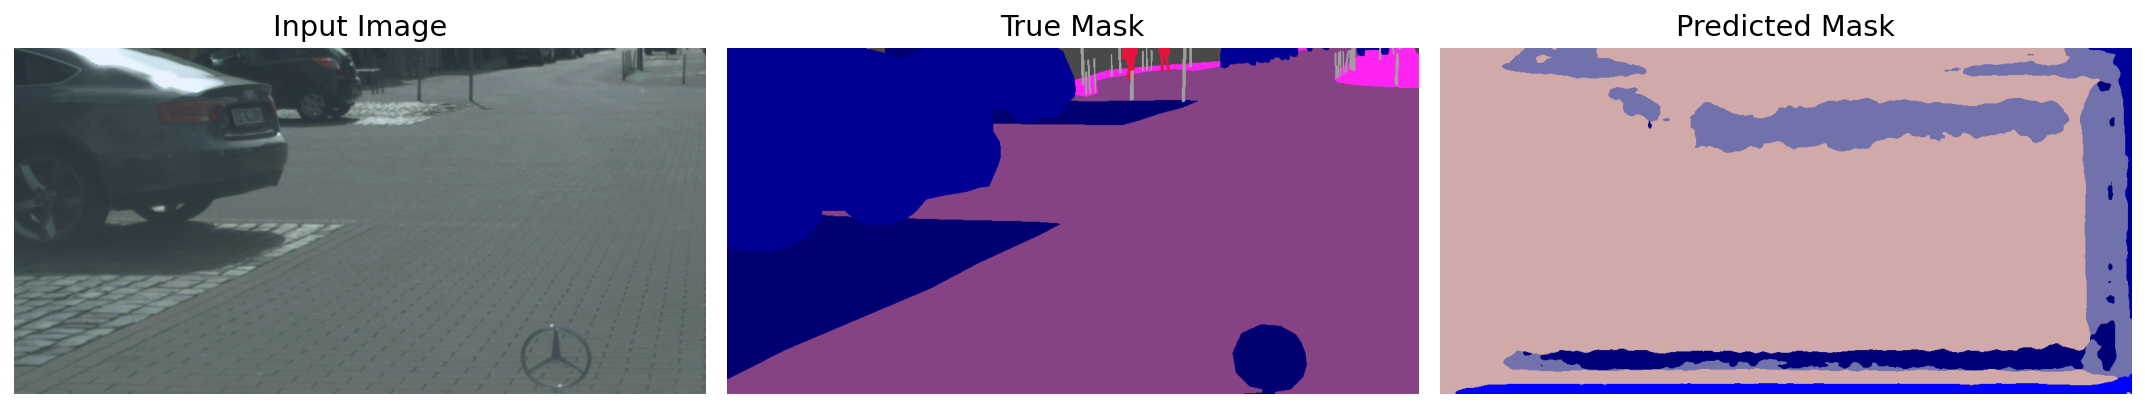

In [19]:
show_predictions()

In [20]:
CURR_EPOCH = 0
EPOCHS = 484 - CURR_EPOCH
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE 
DECAY_STEPS = (STEPS_PER_EPOCH * EPOCHS) # // ACCUM_STEPS
print("Decay steps: {}".format(DECAY_STEPS))

Decay steps: 239580


In [21]:
def get_model():
    """Use for distributed training"""

    with strategy.scope():

        learning_rate_fn = schedules.PolynomialDecay(
            initial_learning_rate = 1e-3, # 0.00046099885
            decay_steps = DECAY_STEPS,
            end_learning_rate=1e-7,
            power=0.9
        )

        
        # model = HRNet(input_height=img_height, input_width=img_width, n_classes=20, W=40)
        model = U2NET(input_height=img_height, input_width=img_width, n_classes=20)
        model.load_weights(MODEL_PATH)

        opt = Adam(learning_rate=learning_rate_fn, decay=0.0005)

        model.compile(
            loss=weighted_cross_entropy_loss, 
            optimizer=opt, 
            metrics=["accuracy", iou_coef_sparse]
        )
        
    return model

In [22]:
learning_rate_fn = PolynomialDecay(
    initial_learning_rate = 5e-3,
    decay_steps = DECAY_STEPS,
    end_learning_rate = 5e-6,
    power = 0.9
)

model.compile(
    optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005), 
    loss = weighted_cross_entropy_loss,
    metrics = ['accuracy', iou_coef]
)

callbacks = [
    # EarlyStopping(monitor='val_iou_coef', mode='max', patience=40, verbose=2),
    # ReduceLROnPlateau(monitor='val_iou_coef', mode='max', patience=10, factor=0.5, min_lr=1e-5, verbose=2),
    ModelCheckpoint(MODEL_PATH, monitor='val_iou_coef', mode='max', 
                    verbose=2, save_best_only=True, save_weights_only=True)    
]

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1
)

In [24]:
model.optimizer._decayed_lr(tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0008858838>

In [25]:
def plot_history(history, model):
        
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,3,1)  
    plt.plot(history['d0_loss'], 'r', label='Training loss')
    plt.plot(history['val_d0_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    plt.plot(history['d0_accuracy'], 'r', label='Training accuracy')
    plt.plot(history['val_d0_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    
    plt.subplot(1,3,3)
    plt.plot(history['d0_iou_coef_sparse'], 'r', label='IoU coefficient')
    plt.plot(history['val_d0_iou_coef_sparse'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    
    plt.savefig("plots/"+model.name+"_learning_curves.png")
    plt.show()

In [26]:
history = model.history.history

KeyError: 'd0_loss'

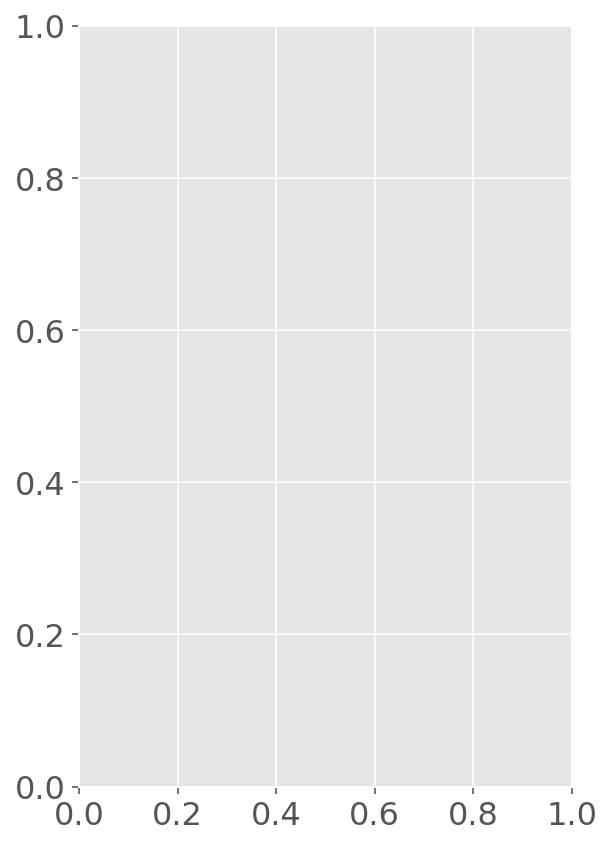

In [27]:
plot_history(history, model)

### Evaluation

In [ ]:
def evaluate_iou(model, dataset, n_samples):
    
    iou_scores = np.zeros((n_samples,))
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time()
        y_pred = model.predict(X)
        t_end = time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "U2Net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
        y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        miou_op.update_state(y_true, y_pred)
        iou = miou_op.result().numpy()
        iou_scores[idx] = iou
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return iou_scores, miou_op

In [ ]:
iou_scores, miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean = np.mean(iou_scores)

In [ ]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

In [ ]:
def plot_iou_catId(catId_label_map, n_classes, iou_class, model, iou_mean):

    categories = [catId_label_map[i].category for i in range(1, n_classes)]
    cat_colors = {
        'void': colors.to_hex(list(np.array(catId_label_map[0].color)/255)),
        'flat': colors.to_hex(list(np.array(catId_label_map[1].color)/255)),
        'construction': colors.to_hex(list(np.array(catId_label_map[2].color)/255)),
        'object': colors.to_hex(list(np.array(catId_label_map[3].color)/255)),
        'nature': colors.to_hex(list(np.array(catId_label_map[4].color)/255)),
        'sky': colors.to_hex(list(np.array(catId_label_map[5].color)/255)),
        'human': colors.to_hex(list(np.array(catId_label_map[6].color)/255)),
        'vehicle': colors.to_hex(list(np.array(catId_label_map[7].color)/255))
    }
    _colors = [cat_colors[category] for category in categories]
    
    fig, ax = plt.subplots(figsize=(14,10))
    hbars = ax.barh(categories, iou_class, color=_colors)
    
    ax.set_xlabel("IoU Coefficient: ", fontsize=18)
    ax.set_ylabel("Category Name", fontsize=18)
    ax.set_title("Category Scores for {} - Mean IoU: {:.3f}".format(model.name, iou_mean), fontsize=22)
    ax.set_xlim([0, 1])
    
    # ax.bar_label(hbars, fmt="%.2f", padding=3, fontsize=16)
    
    plt.savefig("plots/"+model.name+"_category_iou_scores.png")
    plt.show()
    
    
    
def plot_iou_trainId(trainId_label_map, catId_label_map, n_classes, iou_class, model, iou_mean):

    categories = [trainId_label_map[i].category for i in range(1, n_classes)]
    
    cat_colors = {
        'void': colors.to_hex(list(np.array(catId_label_map[0].color)/255)),
        'flat': colors.to_hex(list(np.array(catId_label_map[1].color)/255)),
        'construction': colors.to_hex(list(np.array(catId_label_map[2].color)/255)),
        'object': colors.to_hex(list(np.array(catId_label_map[3].color)/255)),
        'nature': colors.to_hex(list(np.array(catId_label_map[4].color)/255)),
        'sky': colors.to_hex(list(np.array(catId_label_map[5].color)/255)),
        'human': colors.to_hex(list(np.array(catId_label_map[6].color)/255)),
        'vehicle': colors.to_hex(list(np.array(catId_label_map[7].color)/255))
    }
    _colors = [cat_colors[category] for category in categories]

    names = [trainId_label_map[i].name for i in range(1, n_classes)]

    fig, ax = plt.subplots(figsize=(14,10))
    hbars = ax.barh(names, iou_class, color=_colors)
    
    ax.set_xlabel("IoU Coefficient: ", fontsize=18)
    ax.set_ylabel("Class Name", fontsize=18)
    ax.set_title("Class Scores for {} - Mean IoU: {:.3f}".format(model.name, iou_mean), fontsize=22)
    ax.set_xlim([0, 1])
    
    # ax.bar_label(hbars, fmt="%.2f", padding=3, fontsize=16)
    
    plt.savefig("plots/"+model.name+"_class_iou_scores.png")
    plt.show()

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catid2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean,
)

In [ ]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.savefig("plots/"+model.name+"_class_confusion_matrix.png")
    plt.show()

In [ ]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)